Private vs Public LB score
==

[This](https://www.kaggle.com/c/tabular-playground-series-nov-2021/discussion/285503) posts suggests that the labels for this competition have been tampered with, which seems very likely. For the sake of doing some experiments, let's assume that the post is correct, and that 25% of the labels have been selected at random, and flipped. This seems like the most likely explanation for why we're hitting around AUC .75.

But does that actually tell us anything? Well, let's assume for a moment, that we have generated the 1 140 000 total labels to be about balanced, like this: `y_true = np.random.uniform(1140000) < 0.5125`. And that we randomly flipped 25% of them. Can that tell us anything about the maximum AUC that we "should" be scoring on the Public LB, before we're overfitting? To try to answer the question, I will try to run some simulations. A disclaimer here, is that I wrote this code so that it's hopefully easy to follow, it's certainly possibly to make it more efficient.

Original label distribution
--

Did you notice that I wrote `.5125` above? But `mean(y) = .506` according to train set! Well, it turns out, that flipping 25% of the labels will bring `mean(y)` closer to `.5`. In fact, we're likely to end up in the vicinity around `.506` when we do this. What does that mean? Well, the flipped labels have a different distribution than the correct labels. That'll impact practically everything.

In [ ]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import plotly.express as px
from plotly import figure_factory as ff
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm, trange


np.random.seed(42)
random.seed(42)
pd.options.plotting.backend = "plotly"
sns.set(style='darkgrid', context='notebook', rc={'figure.frameon': False, 'figure.figsize': (12, 8)})
n_jobs = cpu_count()

y_true = np.random.uniform(size=1140000) < .5125

pd.Series(y_true, name='y_true').value_counts(normalize=True).plot.bar(title=f'mean(y_true) = {y_true.mean():.5f}')

The Perfect Classifier
==

Now, let's assume that we've built the **perfect** classifier for that. So, it actually predicts, exactly `y_true`, for all of these. It's just that good.

Obviously, the AUC is 1:

In [ ]:
y_pred = np.copy(y_true)

roc_auc_score(y_true, y_pred)

But we don't know that yet, of course. We've only _really_ seen the train set, and been tested on 19% of the test set. We're pretty sure though, because our CV score is 1.0 too.

Someone messes up the labels!
==

But anyway, Kaggle staff found out, and decided that labels must be made more difficult, so they randomly flip about 25% of the labels. Note that, at this point, we make the assumption that the labelflip is random, and completely independent from the features! If that's not the case, the rest of this notebook won't be making much sense.

In [ ]:
flip = np.random.uniform(size=y_true.size) < .25
y_true[flip] = 1 - y_true[flip]

This changes the distribution of `y_true` to what we'd recognize from the training data set:

In [ ]:
pd.Series(y_true, name='y_true').value_counts(normalize=True).plot.bar(title=f'AUC {roc_auc_score(y_true, y_pred):.5f}, mean(y_true) = {y_true.mean():.5f}')

The perfect classifier from earlier, can now only classify around 75% of the data correctly, so it ends up with AUC roughly .75, just like what we're seeing at the top of the leaderboard.

But this isn't actually how the leaderboard score is calculated, so let's make this a bit more complicated, to better model reality.


Simulating data set splits
==

Let's assume, that was kaggle did, was to generate a single, big data set. Then they flipped the labels randomly. After which they split the dataset, first into train/test parts, then they split the test part into public and private. So let's do the same thing.

First we split out the test set, we'll use `sklearn.model_selection.train_test_split` for clarity.

In [ ]:
y_train_true, y_test_true, y_train_pred, y_test_pred = train_test_split(y_true, y_pred, test_size=540000)

CV results from train set
--

So, suppose we still have the perfect classifier, and we validate on some CV splits locally -- we might see these scores:

In [ ]:
cvs = pd.DataFrame({'auc': [
    roc_auc_score(y_train_true[idx_val], y_train_pred[idx_val])
    for _, idx_val in StratifiedKFold(5, shuffle=True).split(y_train_true, y_train_pred)
]})
cvs.plot.bar(y='auc')

In [ ]:
cvs

There's some variation here, but, by and large the scores are similar. Later on, we should check how much more variation there would be if our classifier was not perfect.

But there's one more split going on! The public vs private LB split of the test sets, where the public split is smaller than the private at 19%. In fact, it's actually smaller even than our individual CVs, so it's probably less stable!

The Perfect Classifier Leaderboard Scores
==

So, with that CV performance, how well do we perform on Public LB compared to Private LB with our perfect classifier?

In [ ]:
y_private_true, y_public_true, y_private_pred, y_public_pred = train_test_split(y_test_true, y_test_pred, test_size=.19)

lb = pd.DataFrame({'auc': [
    roc_auc_score(y_public_true, y_public_pred),
    roc_auc_score(y_private_true, y_private_pred)
]}, index=['public', 'private'])
lb.plot.bar(title=f'public AUC {lb.loc["public", "auc"]:.5f}, private AUC {lb.loc["private", "auc"]:.5f}')

In this case, we score worse on Public LB, than on Private LB with our perfect classifier. By quite a margin too, going by the score differences we're seeing right now. 

We don't **know** that it **actually** is like this. But can we try to find out how likely it is?

Well, we can run as many simulations as we'd like, to kind of figure out how all of these numbers relate to each other.

Making a reusable simulation
==

We'll basically do exactly the same thing, except of course, many times. That sounds like exactly the right job for a function, so let's make that. We'll make sure to add a parameter so that we can later experiment with a worse-than-perfect classifier:

In [ ]:
def simulate_tabfun_november(clf_accuracy=1.0, metric=roc_auc_score):
    y_true = (np.random.uniform(size=1140000) < 0.5125).astype(np.float32)
    y_pred = np.copy(y_true)
    if clf_accuracy < 1.0:
        make_wrong = clf_accuracy < np.random.uniform(size=y_pred.size)
        y_pred[make_wrong] = 1 - y_pred[make_wrong]
    flip = np.random.uniform(size=y_true.size) < .25
    y_true[flip] = 1 - y_true[flip]
    y_train_true, y_test_true, y_train_pred, y_test_pred = train_test_split(y_true, y_pred, test_size=540000)
    out = {
        f'cv_{i}': metric(y_train_true[idx_val], y_train_pred[idx_val])
        for i, (_, idx_val) in enumerate(StratifiedKFold(5, shuffle=True).split(y_train_true, y_train_pred))
    }
    out['oof_auc'] = metric(y_train_true, y_train_pred)
    y_private_true, y_public_true, y_private_pred, y_public_pred = train_test_split(y_test_true, y_test_pred, test_size=.19)
    out['public'] = metric(y_public_true, y_public_pred)
    out['private'] = metric(y_private_true, y_private_pred)
    return out

one_run = pd.DataFrame(simulate_tabfun_november(), index=pd.RangeIndex(1))
one_run.melt().plot.bar(x='variable', y='value')

In [ ]:
one_run

And there you go, now we have a reusable simulation to go on. Let's run it a few times:

In [ ]:
summary = pd.DataFrame([
    simulate_tabfun_november() for _ in trange(10)
])
summary

In [ ]:
summary.describe()

What kind of variation can we expect?

In [ ]:
px.box(pd.melt(summary).rename(columns={'variable': 'split', 'value': 'auc'}), x='split', y='auc')

That seems to be quite a range, right? I've certainly had plenty of models that score in this sort of range on local CVs, and I also have submits that score in that min-to-max range of the public LB.

Currently, the public LB is very near .75 AUC. And it's very possible that a perfect classifier might only be able to achieve, for example, .7485 AUC, according to this.

But maybe that's very unlikely. A sample size of 10 is way too low to get us any estimates of how likely that is, anyway. So let's run some more.

Simulating 1000 competitions
==

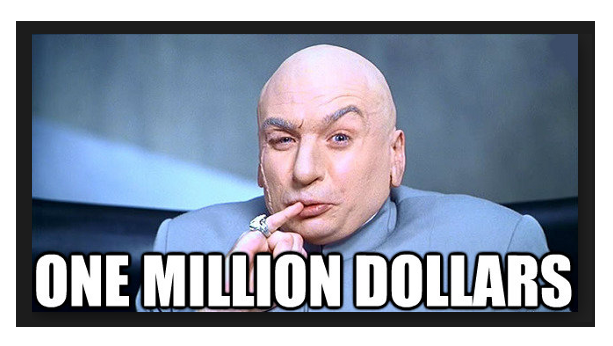

This is going to take a while, because we didn't write this code to be efficient. There's probably also a way to express this with formulas and statistics, rather than doing it this, but my brain is just way too fried to think about that right now and the code came naturally. But let's throw more CPU cores into the mix, for some extra speed:

In [ ]:
tasks = [1.0] * 1000
with Pool(n_jobs) as pool:
    summary = pd.DataFrame(list(tqdm(pool.imap(simulate_tabfun_november, tasks), total=1000)))

In [ ]:
px.box(pd.melt(summary).rename(columns={'variable': 'split', 'value': 'auc'}), x='split', y='auc', title='Splits by AUC after 1000 competitions')

Notice the enormous spans here, especially in public LB!

Split AUC score correlations
--

Now, it might be interesting to check out some correlations here.

In [ ]:
px.imshow(summary.corr(), title=f'Correlation heatmap for {len(tasks)} competitions')

One thing that I'm personally very interested in knowing, is which one out of CV score and Public LB is the best indicator of Private LB score, so let's plot the difference between these, ie plot the three distributions:

- `public - private`
- `oof_auc - public`
- `oof_auc - private`

In [ ]:
ff.create_distplot(
    [summary.private - summary.public, summary.oof_auc - summary.public, summary.oof_auc - summary.private],
    ['Private - Public', 'CV - Public', 'CV - Private'],
    bin_size=.001,
)


According to this, you should trust your CV scores more than the public LB by far, and it's OK if public LB and CV scores disagree. Because they do, even for the perfect classifier!

The Good Classifier
==

Let's relax one assumption we've had so far. We've used a perfect classifier for our study up until now. But what if it turns out that it's only possible to make one that is almost perfect? What happens to our estimates if it turns out that our classifier is only 99.5% accurate? Does that lead to greater variation? Would we be able to tell the difference between the perfect one, and the almost perfect one?

In [ ]:
tasks = [.995] * 1000
with Pool(n_jobs) as pool:
    summary2 = pd.DataFrame(list(tqdm(pool.imap(simulate_tabfun_november, tasks), total=1000)))

px.box(pd.melt(summary2).rename(columns={'variable': 'split', 'value': 'auc'}), x='split', y='auc')

So, it turns out, you should actually be able to tell the difference between the perfect classifier, and the good classifier. Let's plot both together:




In [ ]:
d = pd.concat([summary.assign(clf='perfect'), summary2.assign(clf='good')]).melt(id_vars=['clf'], var_name='split', value_name='auc')
px.box(d, x='split', y='auc', color='clf')

If you're seeing CV scores at around .75 AUC, you're probably doing better than the good classifier is. But it's your CV scores you should be looking at, public LB is much more unstable, and has a bigger overlap!

Should I even keep trying?
==

Personally I'm hitting .75 AUC on CVs, but my best on the Public LB is 0.74880. Does this mean I'm overfitting to my CV, or does it mean that we got unlucky, and got a Public LB selection which is hard, even for the perfect classifier?

Can we inspect our simulation results to find out? Let's find out what the other values distribute to, when Public LB is lower, or equal to .7488:

In [ ]:
px.box(
    summary.loc[summary.public <= .7488].melt(var_name='split', value_name='auc'), 
    x='split', y='auc', title=f'Public LB <= .7488 ({100 * np.mean(summary.public <= .7488):.2f}% of simulations)',
)

Well, wow. I *am* seeing CVs in this range regularly. Does this mean I should just quit trying? Hard to say, but it turns out that for a perfect classifier, Public LB might be less than this score a fair bit of the time...

I'm regularly hitting `oof_auc` over `.75` locally, but I never submit to that score. How's that look with a perfect classifier?

In [ ]:
px.box(
    summary.loc[summary.oof_auc > .75].melt(var_name='split', value_name='auc'), 
    x='split', y='auc', title=f'OOF AUC > .75 ({100 * np.mean(summary.oof_auc > .75):.2f}% of simulations)',
)

And how do the splits distribute for the oof_auc within 25% of the median?

In [ ]:
d = summary.loc[summary.oof_auc.between(summary.oof_auc.quantile(.25), summary.oof_auc.quantile(.75))]

px.box(
    d.melt(var_name='split', value_name='auc'), 
    x='split', y='auc', title=f'OOF near median',
)

Perfect classifier accuracy
==

We've been spending a lot of time looking at AUC, which can seemingly end up over .75.

But how's it look for accuracy? I've ran hundreds of models by now and I am not getting out of fold accuracy over 74.78% (train accuracy is 75% for those). So I want to run some simulations tracking accuracy too:

In [ ]:
from sklearn.metrics import accuracy_score

tasks = [1.0] * 1000
def simulate_tabfun_november_accuracy(accuracy):
    return simulate_tabfun_november(accuracy, metric=accuracy_score)

with Pool(n_jobs) as pool:
    accuracy_summary = pd.DataFrame(list(tqdm(pool.imap(simulate_tabfun_november_accuracy, tasks), total=1000))).rename(columns={'oof_auc': 'oof_accuracy'})

    
px.box(
    accuracy_summary.melt(var_name='split', value_name='accuracy'),
    x='split', y='accuracy', title='Perfect classifier accuracy'
)

Good classifier accuracy vs perfect comparison
--

In [ ]:
tasks = [.995] * 1000

with Pool(n_jobs) as pool:
    accuracy_summary2 = pd.DataFrame(list(tqdm(pool.imap(simulate_tabfun_november_accuracy, tasks), total=1000))).rename(columns={'oof_auc': 'oof_accuracy'})

d = pd.concat([accuracy_summary.assign(clf='perfect'), accuracy_summary2.assign(clf='good')]).melt(id_vars=['clf'], var_name='split', value_name='accuracy')
px.box(d, x='split', y='accuracy', color='clf')

Writing the results
==

In case somebody else might want to play with these results, I'm writing out:

- `summary_perfect.csv` is 1000 rounds of simulated scores for the perfect classifier
- `summary_accuracy.csv` is 1000 rounds of simulated accuracy scores for the perfect classifier
- `summary_good.csv` is 1000 rounds of simulated scores for the good classifier

If you followed along this far, thanks a lot for reading, let me know if you learned something, or have suggestions for improvements!

In [ ]:
summary.to_csv('/kaggle/working/summary_perfect.csv', index=False)
summary2.to_csv('/kaggle/working/summary_good.csv', index=False)
accuracy_summary.to_csv('/kaggle/working/summary_accuracy_perfect.csv', index=False)
accuracy_summary2.to_csv('/kaggle/working/summary_accuracy_good.csv', index=False)